# Comparison of arrival direction and joint models

In order to verify the model is working, we fit simulations made under the model assumptions. As an extension, we also compare the differences between a model for only the UHECR arrival directions and one for both the UHECR arrival directions and energies.

In [1]:
import numpy as np
import h5py
from matplotlib import pyplot as plt

# For testing
import sys
sys.path.append('../../../../fancy')

from fancy import Data, Model, Analysis, Results

/Users/fran/projects/bayes/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Simulation

Set up a simulation using randomly selected sources and the Pierre Auger Observatory as a detector. This simulation will include all the processes described in Section 2 of the paper. 

In [2]:
# Define file containing source catalogue information
source_file = '../../../data/sourcedata.h5'

# Define random seed for reproducible results
random_seed = 1992071502

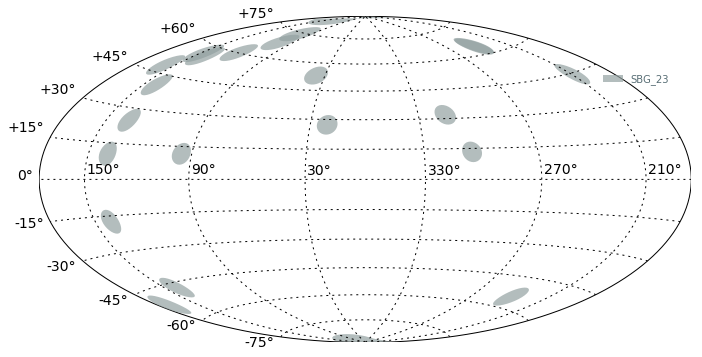

In [3]:
from fancy.detector.auger2014 import auger_location,theta_m,A,alpha_T,M, Merr,kappa_c

# Define a source catalogue and detector exposure
# In the paper we use the SBG catalogue
data = Data()
data.add_source(source_file, r'SBG_23')
data.add_detector(auger_location, theta_m, A, alpha_T, kappa_c, 'PAO')

# Plot the sources in Galactic coordinates
data.show();

In [35]:
stan_path = '../../../stan/'

# Define a Stan simulation to run
sim_name = stan_path + 'joint_model_sim.stan' # simulate all processes

# Choose a model to fit
#model_name = stan_path + 'arrival_direction_only.stan'
model_name = stan_path + 'joint_model.stan'

# Define Model object and compile Stan code if necessary
model = Model(model_name, sim_name, include_paths = stan_path)
model.compile()

INFO:pystan:COMPILING THE C++ CODE FOR MODEL sim_507c32bed62f69d11b1b80429f39b188 NOW.


Using cached StanModel


In [36]:
from fancy.detector.auger2014 import f_E

# Define associated fraction
f = 0.5 

# Simulation input
B = 20 # nG
alpha = 3.0
Eth = 52
Eth_sim = 20
Eerr = f_E

Nsim = 2500 
FT = (Nsim * M) / alpha_T # km^-2 yr^-1
Fs = f * FT
F0 = (1 - f) * FT

# Convert to luminosity
D = data.source.distance
Mpc_to_km = 3.086E19

# Equal luminosities
L = ( Fs / (sum([1 / (4 * np.pi * (d * Mpc_to_km)**2) for d in D])) ) 
L = np.tile(L, len(D))

# To scale between definition of flux in simulations and fits
flux_scale = (Eth / Eth_sim)**(1 - alpha)

model.input(B = B, L = L, F0 = F0,
            alpha = alpha, Eth = Eth, Eerr = Eerr)

In [37]:
# Define analysis output file to store outputs
output_file = 'output/joint_model_simulation.h5'

# What is happening 
summary = b'Fit of joint simulation with arrival direction model' # must be a byte str
    
analysis = Analysis(data, model, analysis_type = 'joint', 
                    filename = output_file, summary = summary)

In [38]:
# Define location of precalculated values used in fits 
# (see relevant notebook for how to calculatethese files) 
# Each catalogue has a table file
table_file = '../../../data/integration_tables_50_SBG23.h5'
analysis.use_tables(table_file)

In [39]:
# Run simulation

# Build these tables for the simulation as you go
# So that you can try out different parameters
analysis.build_tables(sim_only = True)

analysis.simulate(seed = random_seed, Eth_sim = Eth_sim)
analysis.save_simulation()

3.7311369626670317 7243.664780290348 8.14596470808773e-05
2.749319325916114 1524.5920032375604 1.7632180010523587e-05
2.5264031964180713 1718.560280939578 2.143846036726166e-05
2.5264031964180713 8212.092605049002 8.064448229561094e-05
2.5264031964180713 7206.371812205257 9.436514318820083e-05
1.7068228181413596 2672.7483916941496 3.499138641941747e-05
1.5173398994363259 4274.484847295306 5.3118754567307416e-05
1.2914454692063115 3657.436213143173 5.4431755395511646e-05
1.2404689826558055 4735.395832029348 5.9376435020102794e-05
1.2404689826558055 4759.366537832785 5.958189585389176e-05
1.1663744529794036 4084.511560627019 5.649122864194272e-05
0.9862289425878192 3868.83463758204 5.758334984026962e-05
0.921162340429848 4061.875520502206 5.886707171517838e-05
0.8950933196173849 3823.4854719821064 2.8938362537766212e-05
0.682063739027883 4962.759441656415 6.881404426257475e-05
0.6308989177323534 4033.05243131096 3.328618736071275e-05
0.593219385717117 4289.925280928818 6.295873519623969e

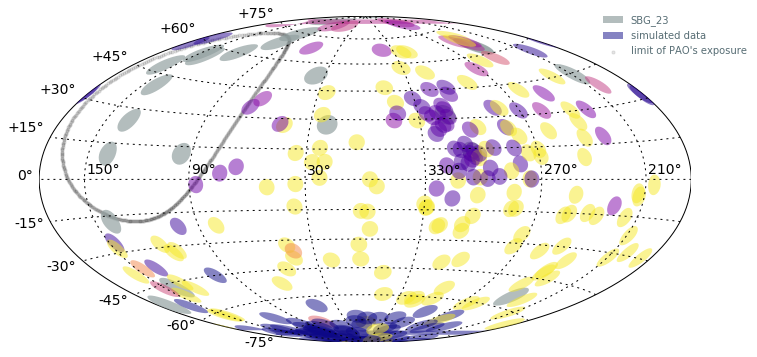

In [40]:
analysis.plot_simulation('arrival direction')

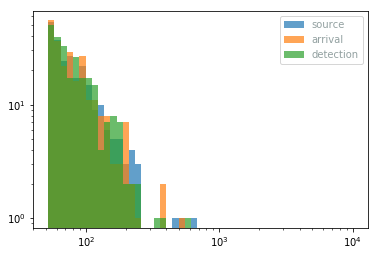

In [41]:
analysis.plot_simulation('energy')

## Fit the arrival direction model

In [42]:
fit = analysis.fit_model(chains = 4, iterations = 2000, seed = random_seed)

0 of 4000 iterations saturated the maximum tree depth of 10 (0.0%)
0.0 of 4000 iterations ended with a divergence (0.0%)
E-BFMI indicated no pathological behavior
n_eff / iter looks reasonable for all parameters
Rhat for parameter lambda[8] is nan!
Rhat for parameter lambda[11] is nan!
Rhat for parameter lambda[69] is nan!
Rhat for parameter lambda[128] is nan!
Rhat for parameter lambda[139] is nan!
Rhat for parameter lambda[150] is nan!
Rhat for parameter lambda[152] is nan!
Rhat for parameter lambda[182] is nan!
  Rhat above 1.1 indicates that the chains very likely have not mixed


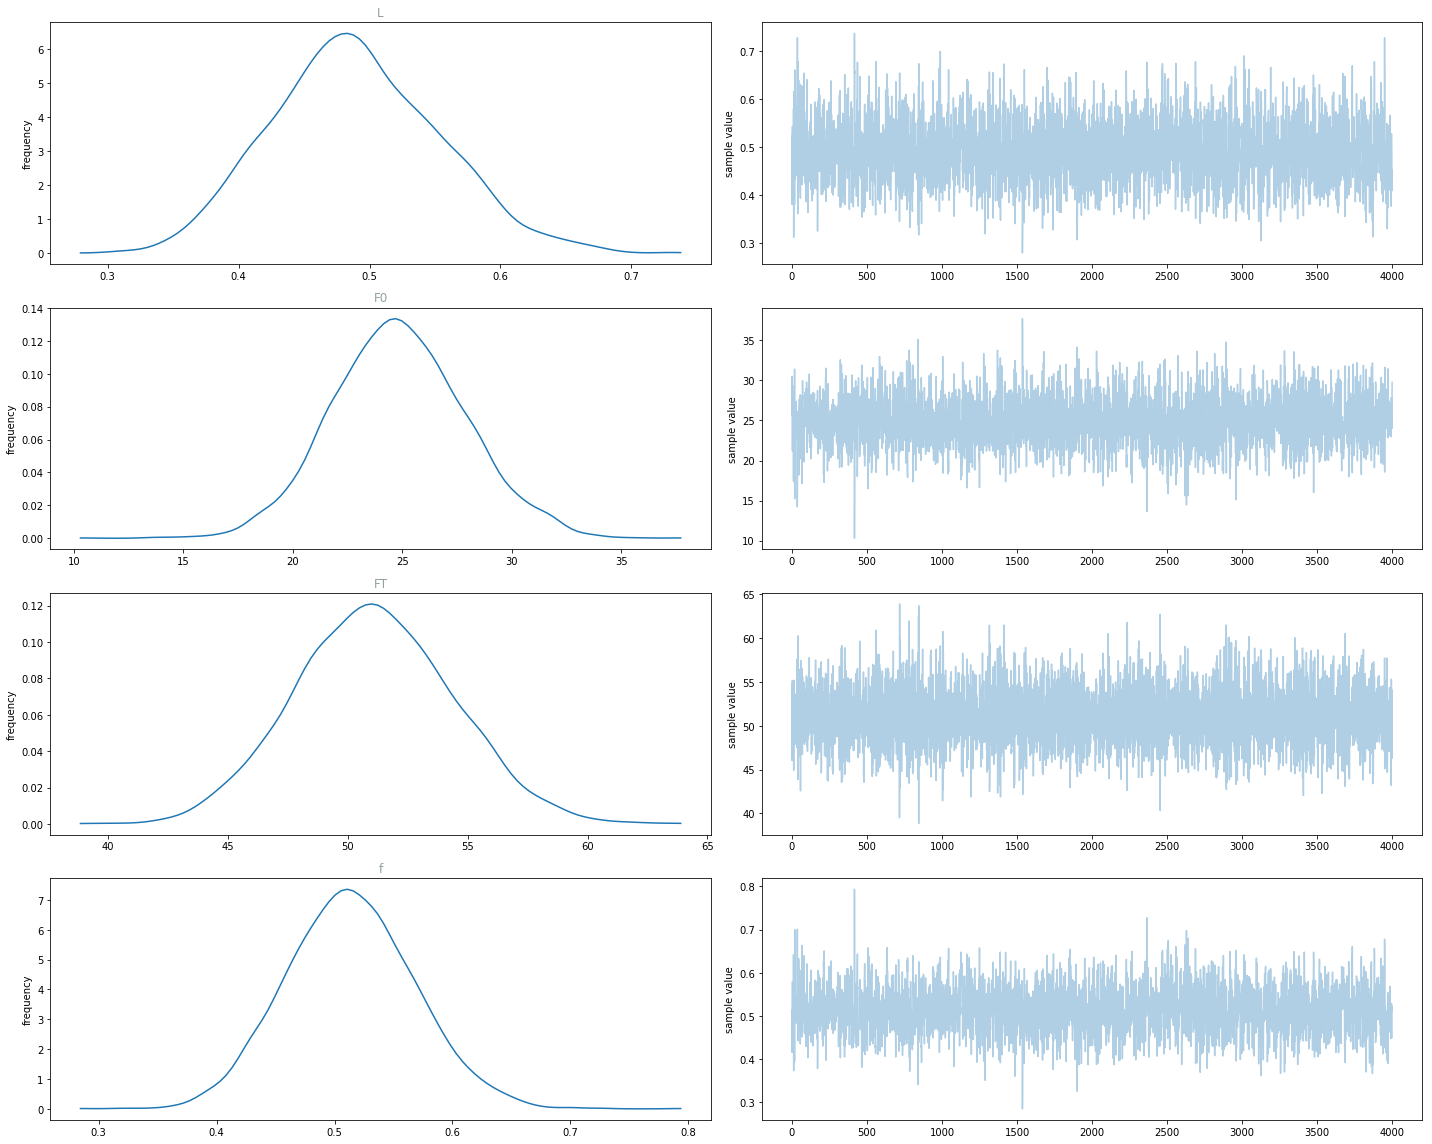

In [43]:
chain = fit.extract(permuted = True)
fig = fit.plot(['L', 'F0', 'FT', 'f'])
fig.set_size_inches(20, 16)
fig.tight_layout()

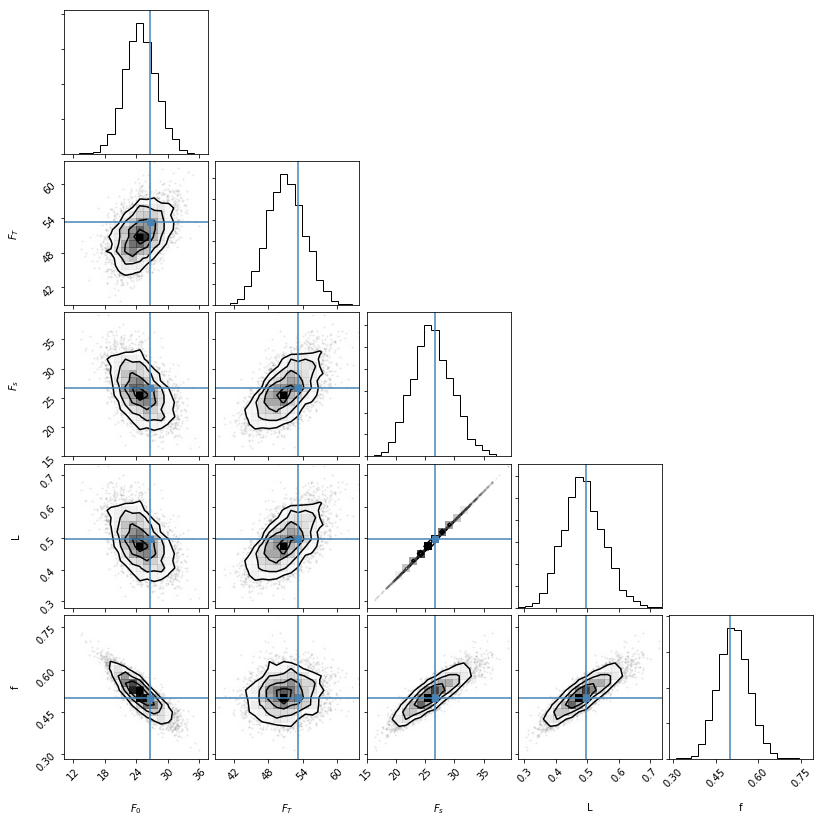

In [44]:
import corner
key_list = ['F0', 'FT', 'Fs', 'L', 'f']
labels = [r'$F_0$', r'$F_T$', r'$F_s$', r'L', 'f']
truths = [F0 * 1e3 * flux_scale, FT * 1e3 * flux_scale, f * FT * 1e3 * flux_scale, 
          (L[0] / 1e39) * flux_scale, f]

corner.corner(np.nan_to_num(np.column_stack([chain[key] for key in key_list])),
              labels = labels, 
              truths = truths);

## Fit the joint model

In [ ]:
## Add to this.




## Compare the arrival direction and joint models